In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Import regular packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import pickle
import itertools
from datetime import datetime
from astropy.time import Time
import os
from seticore import viewer
# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()
assert(hostname == "cosmic-gpu-1")

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [4]:
# Convert a filepath from pointing to a .hits
# to a .stamps file for the same uri
def stamp_filepath_of(hits_filepath):
    return hits_filepath.replace('.hits', '.0000.stamps')

# Load in all the hits which share a common stamp
in_first_stamp = pd.read_csv("/home/nstiegle/BL-COSMIC-2024-proj/stamps/hits_in_first_stamp.csv")
print(in_first_stamp.shape)
# Get the stamp URI for each hit
in_first_stamp["stamp_uri"] = [stamp_filepath_of(uri) for uri in in_first_stamp["file_uri"]]
assert(len(in_first_stamp["stamp_uri"].unique()) == 1)

(85, 29)


In [5]:
# Get the stamps out of the stamp file
stamp_uri = in_first_stamp["stamp_uri"].unique()[0]
stamp_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
stamps = []
for stamp in stamp_gen:
    assert(stamp != None)
    assert(stamp.recipe != None)
    stamps.append(stamp)

print("found", len(stamps), "stamps")

found 49 stamps


/home/nstiegle/miniforge3/envs/stamp_viewer/lib/python3.7/site-packages/seticore/viewer.py:125: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(filepath)


In [6]:
# So there are 85 hits but only 49 stamps :|
# Are some maybe the coherent and incoherent beams?
# What are the file_local_enumerations?
print("So the maximum and minimum file local enumerations are", in_first_stamp["file_local_enumeration"].min(), in_first_stamp["file_local_enumeration"].max())
print("There are", len(in_first_stamp["file_local_enumeration"].unique()), "'enumerations'")

# Are there coherent/incoherent?
print(f"The different sources are {in_first_stamp['source_name'].unique()}")

So the maximum and minimum file local enumerations are 0 84
There are 85 'enumerations'
The different sources are ['3127348761205770496' 'Incoherent']


In [7]:
# How do we group the coherent and incoherent from the same target?
incoherents = in_first_stamp[in_first_stamp['source_name'] == "Incoherent"]
coherents = in_first_stamp[in_first_stamp['source_name'] == "3127348761205770496"]
print(f"There are {len(incoherents)} incoherent hits and {len(coherents)} coherent hits")

There are 37 incoherent hits and 48 coherent hits


In [8]:
## Look at the ordering of coherent vs. incoherent in the file

# Describe how elements are ordered in a series
# Takes: array of elements
# Returns: nothing
# Prints: description
def describe_series_ordering(series):
    # Setup
    prev_value = None
    count = 0
    total_count = 0
    first_time = True

    # Loop through all elements
    for value in series:
        # Increment the number of this thing we've seen
        count += 1

        # Check if we have a previous value
        if prev_value != None:
            # If we do, check if this is the same as the one before
            # If it is, we do nothing,
            # Otherwise, we have to print that we switched
            if value != prev_value:
                if first_time:
                    print(f"Starts with {count} {prev_value}'s")
                    first_time = False
                else:
                    print(f"Followed by {count} {prev_value}'s")
                # Save how many total elements we've seen (as a check)
                total_count += count
                # Reset the count
                count = 0
                # Now this is the element in the run that we're counting
                prev_value = value
        else:
            # This is our first element, so save it as the previous
            prev_value = value

    # Print final results
    total_count += count
    print(f"Finally followed by {count} {prev_value}'s")
    print(f"For {total_count} total (expect {len(series)})")

describe_series_ordering(in_first_stamp.source_name.values)

Starts with 30 3127348761205770496's
Followed by 29 Incoherent's
Followed by 19 3127348761205770496's
Finally followed by 7 Incoherent's
For 85 total (expect 85)


In [9]:
# See if grouping by frequency (to put the coherent and corresponding incoherents together)
groups = in_first_stamp.groupby("signal_frequency")
print(f"There are {len(groups)} groups when grouped by frequency")
print(f'{sum(groups.size() == 1)} of the groups have just 1 element and {sum(groups.size() == 2)} have 2 elements ({sum(groups.size() == 1) + 2 * sum(groups.size() == 2)} elements total)')
print(f"There are {len(stamps)} stamps...")

There are 50 groups when grouped by frequency
15 of the groups have just 1 element and 35 have 2 elements (85 elements total)
There are 49 stamps...


In [10]:
# Let's look at that first group
print("Looking at the first group (which has 2 elements in it)")
fmin = in_first_stamp["signal_frequency"].min()
group = groups.get_group(fmin)
assert(len(group) == 2) # Group w/incoherent and coherent
print("So we have the incoherent and the coherent beam")
print("Interestingly, the file_local_enumeration matches the index of the df...")
assert(len(in_first_stamp["id"]) == len(in_first_stamp["id"].unique())) # All IDs are unique
assert(in_first_stamp["id"].equals(in_first_stamp["id"].copy().sort_values())) # IDs are in sorted, ascending order
assert((in_first_stamp['id'].max() - in_first_stamp['id'].min()) == (len(in_first_stamp["id"]) - 1)) # IDs are sequential
print("where the df is everything in this stamp file (sorted by ascending ID)")
print(f'The difference between their ids is {abs(group.iloc[0]["id"] - group.iloc[1]["id"])} and the difference between their file_local_enumerations is {abs(group.iloc[0]["file_local_enumeration"] - group.iloc[1]["file_local_enumeration"])}')
group
assert(in_first_stamp.file_local_enumeration.equals(in_first_stamp.file_local_enumeration.copy().sort_values())) # file_local_enumerations are sequential
assert(in_first_stamp.file_local_enumeration.min() == 0) # And they start at 0
print(f"And the file_local_enumerations it turns out just count up from {in_first_stamp.file_local_enumeration.min()} to {in_first_stamp.file_local_enumeration.max()}")

Looking at the first group (which has 2 elements in it)
So we have the incoherent and the coherent beam
Interestingly, the file_local_enumeration matches the index of the df...
where the df is everything in this stamp file (sorted by ascending ID)
The difference between their ids is 28 and the difference between their file_local_enumerations is 28
And the file_local_enumerations it turns out just count up from 0 to 84


In [11]:
# Do any groups have just incoherent or just coherent?
num_just_coherent = 0
num_just_incoherent = 0
num_both = 0
for f, group in groups:
    unique_names = group.source_name.unique()
    if len(unique_names) == 2:
        num_both += 1
    elif unique_names[0] == "Incoherent":
        num_just_incoherent += 1
    else:
        num_just_coherent += 1

print(f"There are {num_both} with both, {num_just_coherent} with just coherent and {num_just_incoherent} with just the incoherent")

There are 35 with both, 13 with just coherent and 2 with just the incoherent


In [12]:
# So how do we figure out which item in the hits database corresponds to which element in the stamp file?
# Let's investigate which ones have frequencies which match
stamps_matches = []
stamp_frequencies = np.array([stamp.stamp.signal.frequency for stamp in stamps])
for frequency in stamp_frequencies:
    # Look for hits which match this stamp
    matches = []
    for i, f in enumerate(in_first_stamp["signal_frequency"]):
        if f == frequency:
            matches.append(i)
    stamps_matches.append(matches)

In [13]:
# Let's see if every stamp had a match
num_matches = np.array([len(matches) for matches in stamps_matches])
print(f'There are {(num_matches == 0).sum()} stamps with NO matches, {(num_matches == 1).sum()} stamps with 1 match, {(num_matches == 2).sum()} stamps with 2 matches and {(num_matches > 2).sum()} stamps with more than 2 matched hits')
print(f'''That's {(num_matches == 0).sum()}x0 + {(num_matches == 1).sum()}x1 + {(num_matches == 2).sum()}x2 = {(num_matches == 1).sum() + (num_matches == 2).sum() * 2} hits accounted for of ({len(in_first_stamp.signal_frequency)}), so {len(in_first_stamp.signal_frequency) - ((num_matches == 1).sum() + (num_matches == 2).sum() * 2)} missing''')

There are 6 stamps with NO matches, 12 stamps with 1 match, 31 stamps with 2 matches and 0 stamps with more than 2 matched hits
That's 6x0 + 12x1 + 31x2 = 74 hits accounted for of (85), so 11 missing


In [14]:
# See if the stamps with no matches are due to a rounding error
# See if there are any hits with frequencies within like .1Hz of the stamp frequencies
stamps_with_no_matches = np.where(num_matches == 0)[0]
for index in stamps_with_no_matches:
    stamp_frequency = stamp_frequencies[index]
    diffs = abs(in_first_stamp["signal_frequency"] - stamp_frequency)
    indices_with_hit = (diffs < 1e-7)
    matches = np.where(indices_with_hit)[0]
    print(f'Stamp at {stamp_frequency}MHz had {indices_with_hit.sum()} matches {matches}')
    stamps_matches[index] = matches

Stamp at 43255.57592190021MHz had 2 matches [21 49]
Stamp at 43256.30264461749MHz had 2 matches [ 4 32]
Stamp at 43255.740558512145MHz had 2 matches [11 39]
Stamp at 43255.75242031329MHz had 1 matches [57]
Stamp at 43272.885328180724MHz had 1 matches [60]
Stamp at 43287.29416073077MHz had 2 matches [74 83]


In [15]:
# Let's see if every stamp had a match
new_num_matches = np.array([len(matches) for matches in stamps_matches])
print('After that:')
print(f'There are {(new_num_matches == 0).sum()} stamps with NO matches, {(new_num_matches == 1).sum()} stamps with 1 match, {(new_num_matches == 2).sum()} stamps with 2 matches and {(new_num_matches > 2).sum()} stamps with more than 2 matched hits')
print(f'''That's {(new_num_matches == 0).sum()}x0 + {(new_num_matches == 1).sum()}x1 + {(new_num_matches == 2).sum()}x2 = {(new_num_matches == 1).sum() + (new_num_matches == 2).sum() * 2} hits accounted for of ({len(in_first_stamp.signal_frequency)}), so {len(in_first_stamp.signal_frequency) - ((new_num_matches == 1).sum() + (new_num_matches == 2).sum() * 2)} missing''')

After that:
There are 0 stamps with NO matches, 14 stamps with 1 match, 35 stamps with 2 matches and 0 stamps with more than 2 matched hits
That's 0x0 + 14x1 + 35x2 = 84 hits accounted for of (85), so 1 missing


In [25]:
# Figure out what the one hit with no match is
# Also ensure that no hits are being counted twice or anything

# Collect all the hit indices from the matches collection
# Make sure there are no duplicates
hits_in_matches = []
for stamp_index, matches in enumerate(stamps_matches):
    for num_of_match, match in enumerate(matches):
        if match in hits_in_matches:
            print(f"Hit {match} (the {stamp_index}th stamp's {num_of_match} match) has been seen before")
        else:
            hits_in_matches.append(match)

# Look at all the hits which have matched a stamp file
hits_in_matches = np.array(hits_in_matches)
print(len(hits_in_matches), 'hits as expected')
print(np.sort(hits_in_matches))

# Figure out what the one outlier is
outlier = None
for num in range(85):
    if num not in hits_in_matches:
        assert(outlier == None) # Don't have 2
        print("hit", num, "is the outlier")
        outlier = num

# Print some info about it
outlier_hit = in_first_stamp.iloc[outlier]
outlier_f = outlier_hit.signal_frequency
print(f"The outlier hit is of {outlier_hit.source_name} and at frequency {outlier_f}")
diffs = abs(stamp_frequencies - outlier_f)
outlier_stamp_index = np.where(diffs < 10e-6)[0][0] # Find the stamp which is within 10hz
print(f"The closest stamp frequency to the frequency of the outlier is stamp {outlier_stamp_index} which is {min(diffs)*1e6}Hz away {stamp_frequencies[outlier_stamp_index]}MHz")
print("So this stamp must have contained another, weaker hit and that hit got saved as well, and the outlier is that hit!")
print("I guess there's a range of frequencies a hit can be in to be in the stamp file")
diffs = abs(in_first_stamp["signal_frequency"] - outlier_f)
other_hit_in_stamp_index = np.where(diffs < 10e-6)[0][1]
other_hit = in_first_stamp.iloc[other_hit_in_stamp_index]
other_hit_f = other_hit.signal_frequency
print(f"The closest other hit is hit {other_hit_in_stamp_index} of {other_hit.source_name} at {other_hit_f} which is {abs(outlier_f - other_hit_f)*1e6}Hz away")

84 hits as expected
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 77 78 79 80 81 82 83 84]
hit 76 is the outlier
The outlier hit is of 3127348761205770496 and at frequency 43287.27116955035
The closest stamp frequency to the frequency of the outlier is stamp 44 which is 1.9073486328125Hz away 43287.2711714577MHz
So this stamp must have contained another, weaker hit and that hit got saved as well, and the outlier is that hit!
I guess there's a range of frequencies a hit can be in to be in the stamp file
The closest other hit is hit 82 of Incoherent at 43287.2711714577 which is 1.9073486328125Hz away


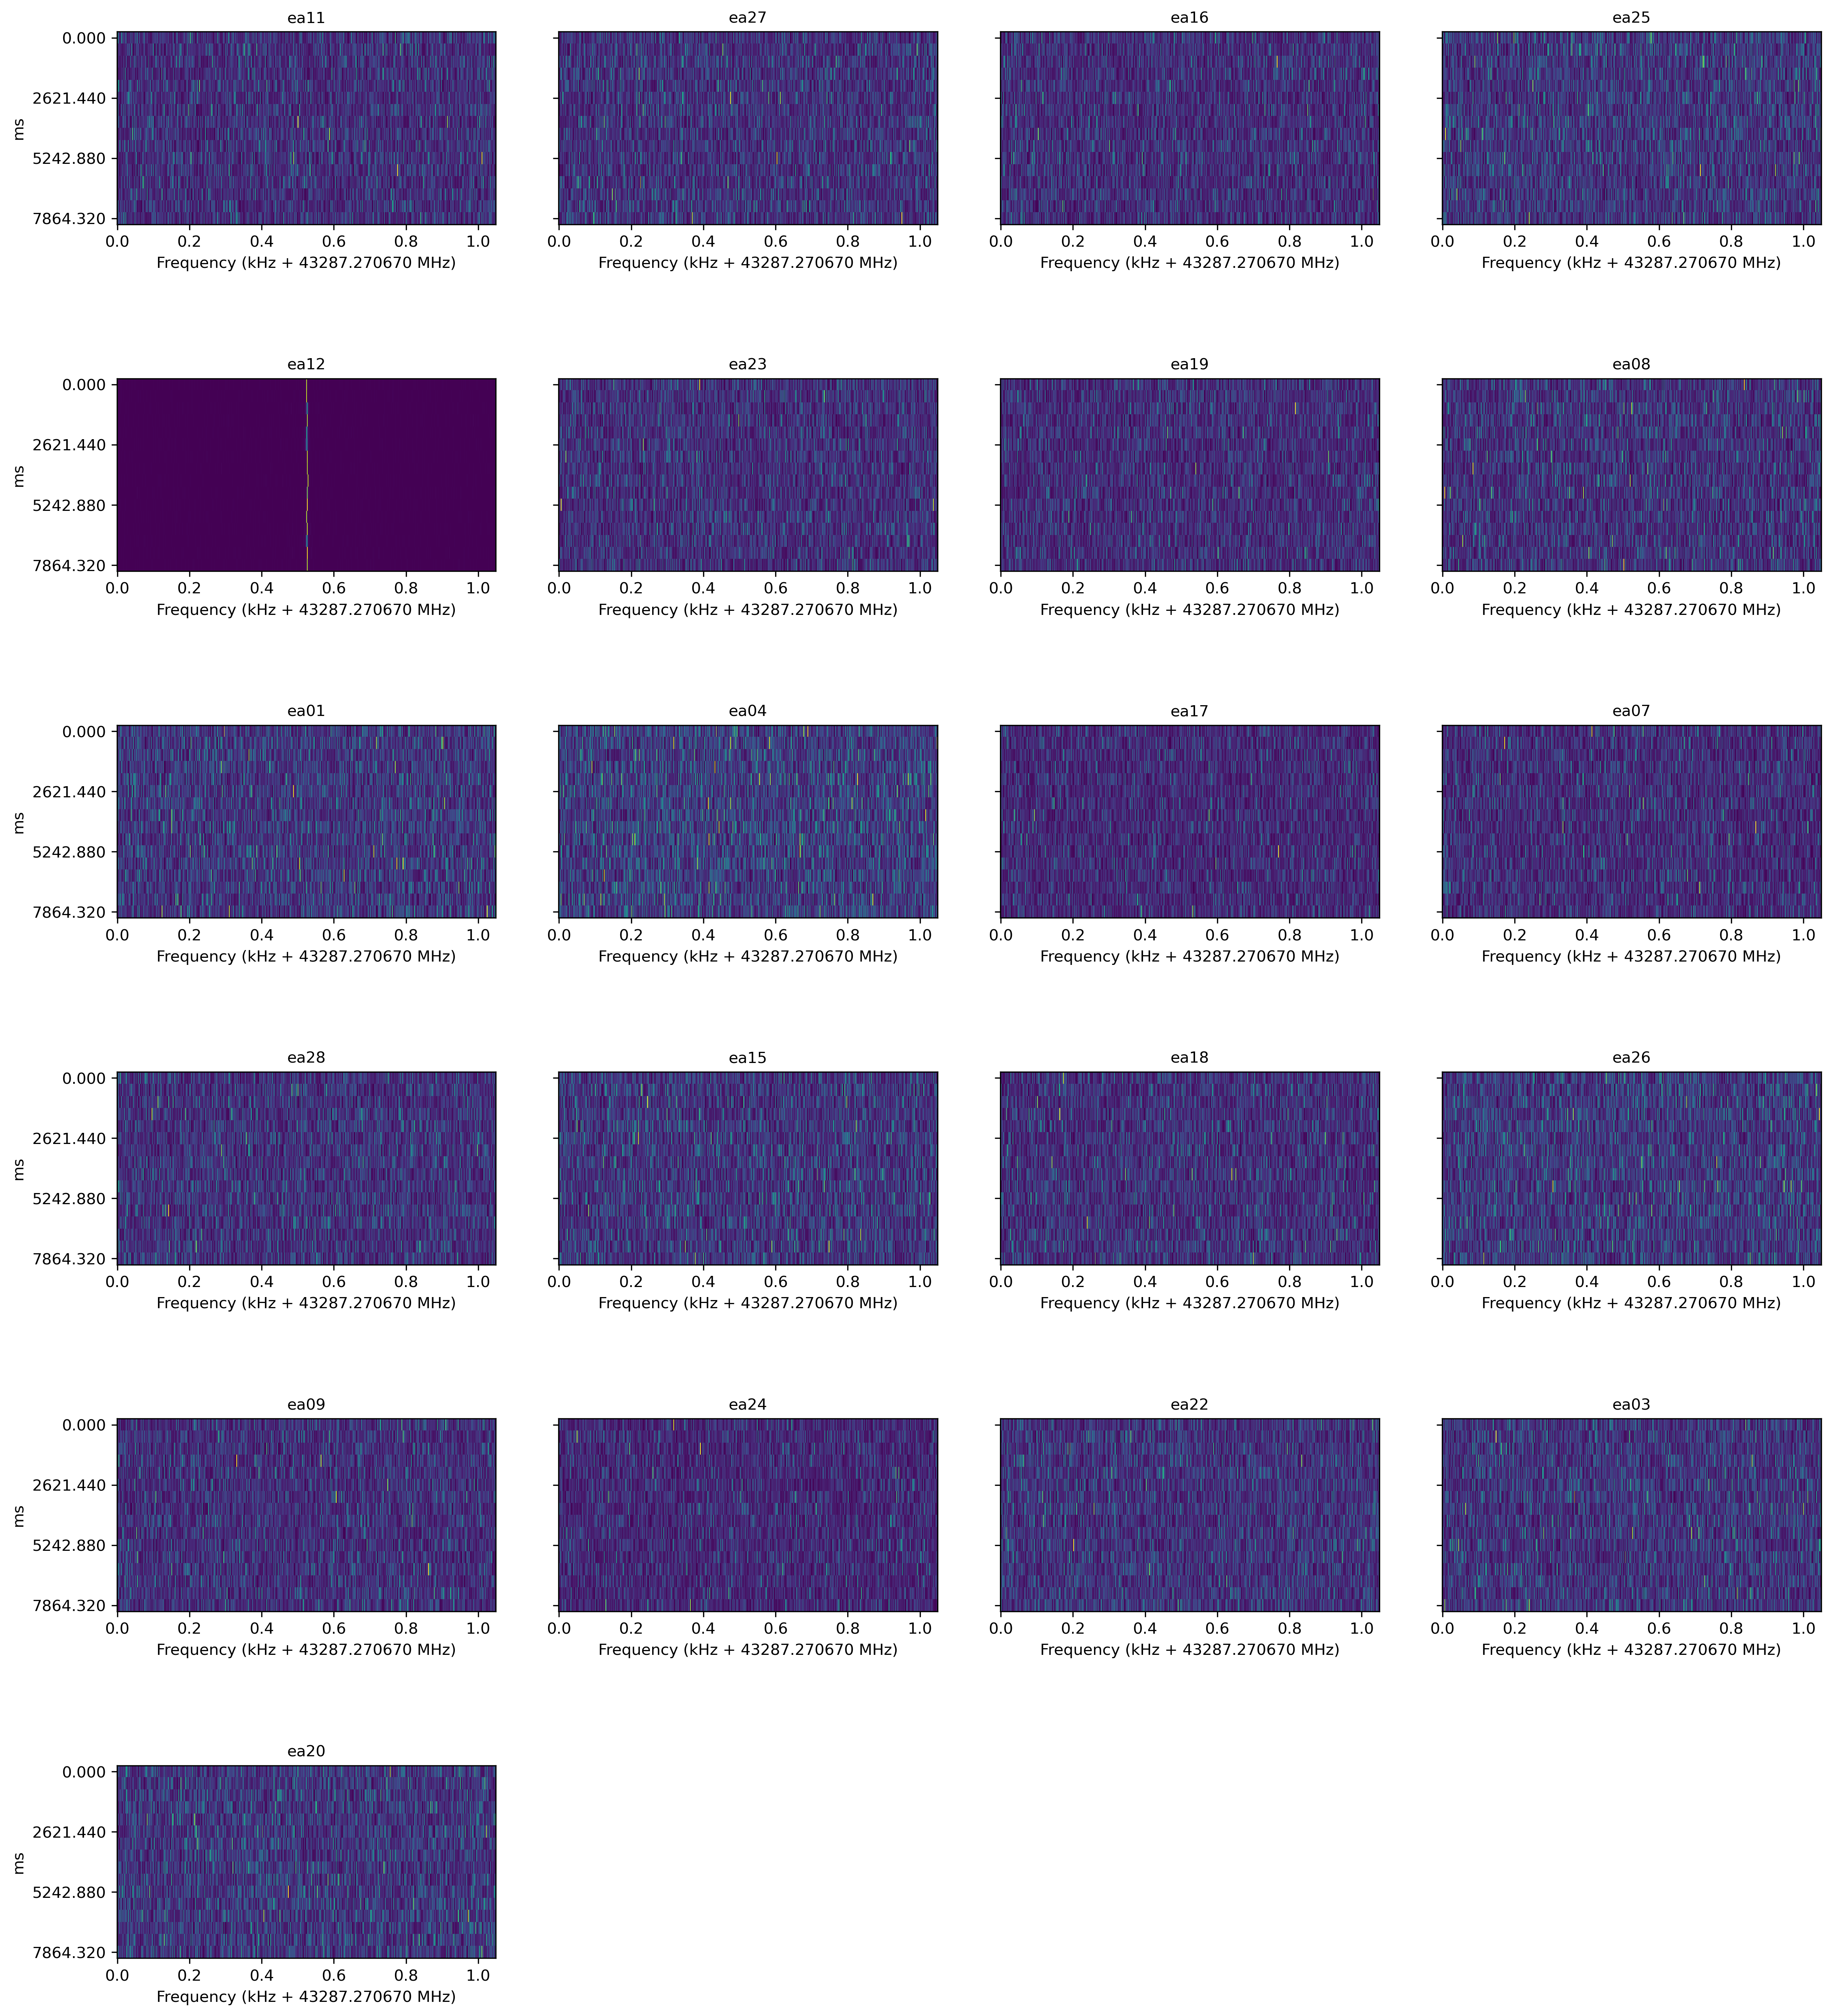

recalculated power: 1.484473e+12
local SNR: 182.4225667726243


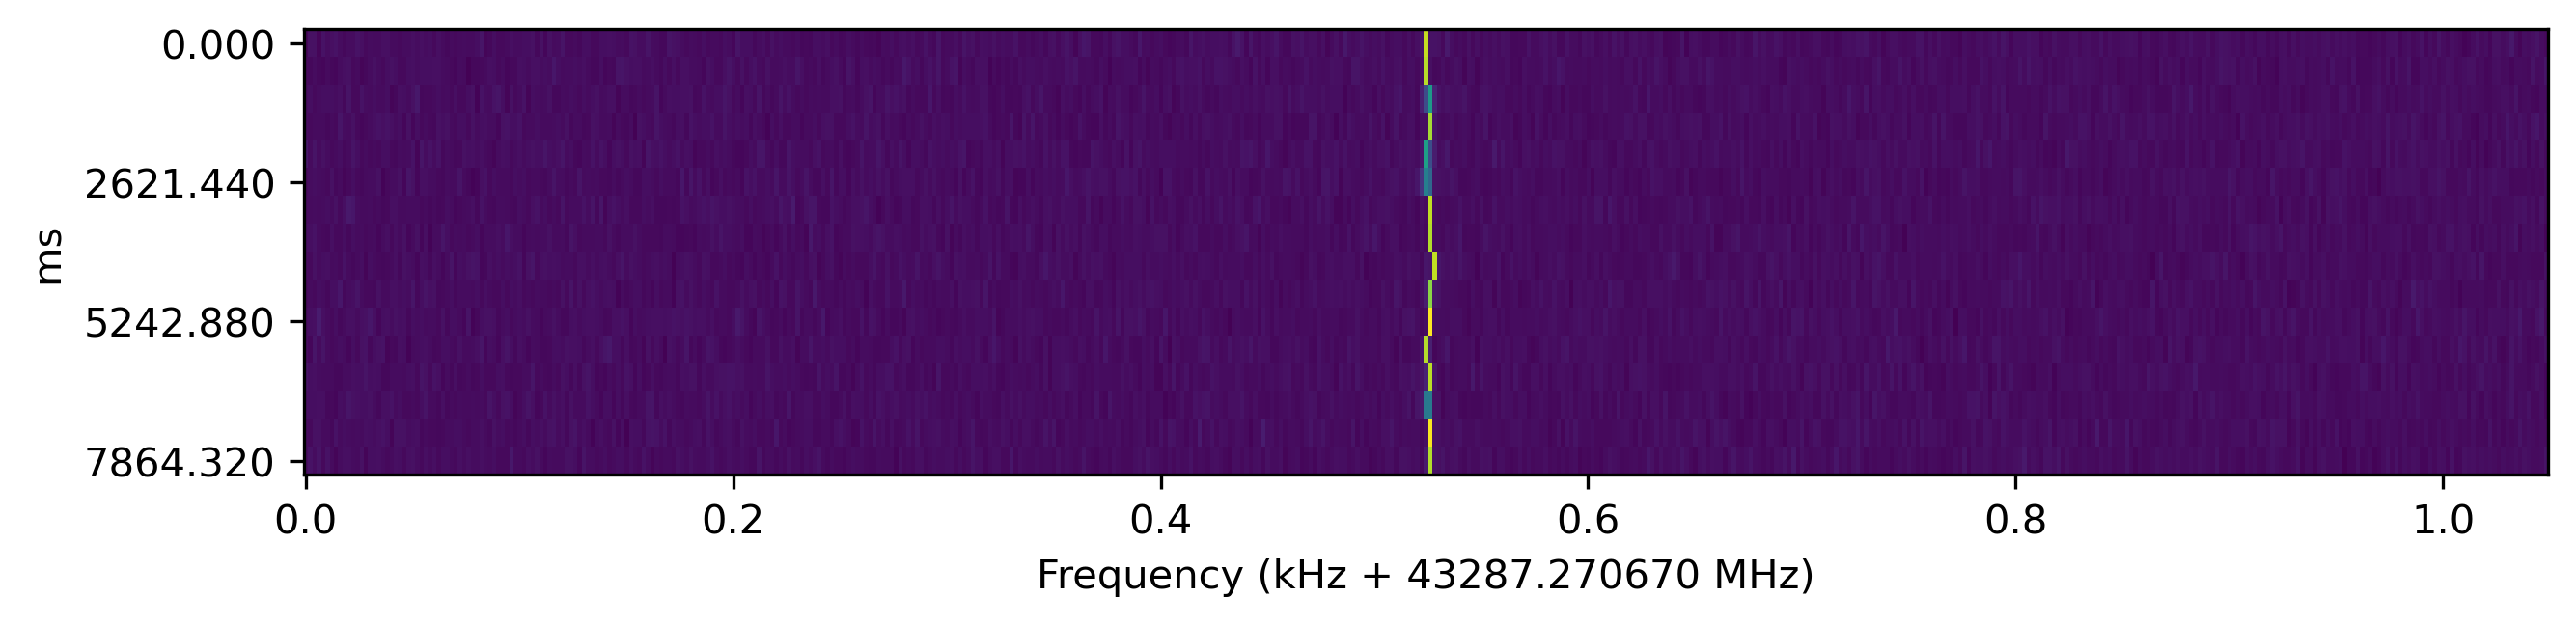

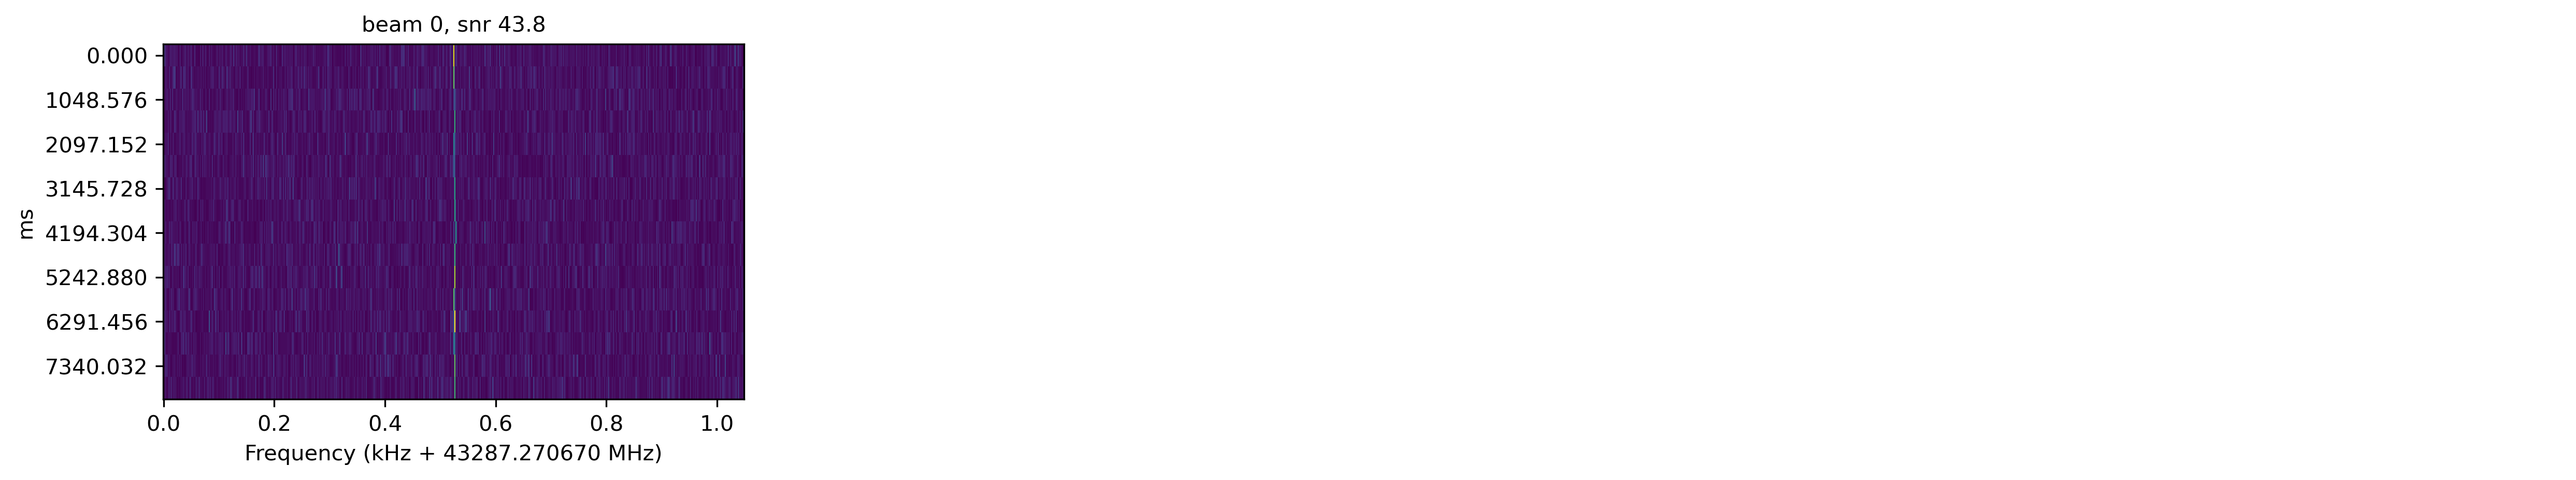

In [17]:
# Let's look at that stamp file to see what's there
stamp_of_outlier = stamps[outlier_stamp_index]
stamp_of_outlier.show_antennas()
stamp_of_outlier.show_classic_incoherent()
stamp_of_outlier.show_beams()


In [27]:
# Looks like the signal got picked up as 2 separate signals 1 frequency bin apart
# Maybe because it wiggles back and forth between the frequency bins

# Print stamp info
print("From the stamp")
print(stamp_of_outlier.stamp.signal.frequency)
print(stamp_of_outlier.stamp.signal.snr)
print(stamp_of_outlier.stamp.signal.driftRate)
print()

# Print outlier info
print("From the outlier")
print(outlier_f)
print(outlier_hit.signal_snr)
print(outlier_hit.signal_drift_rate)
print()

# From the other hit which corresponds to this stamp
print("From the other signal")
print(other_hit.signal_frequency)
print(other_hit.signal_snr)
print(other_hit.signal_drift_rate)
print()

print("So the 'outlier' didn't get chosen for the stamp file because it is slightly weaker in SNR. It also got saved because it's in the stamp file")

From the stamp
43287.2711714577
27.609628677368164
0.0

From the outlier
43287.27116955035
25.114665985107425
0.2425319204727809

From the other signal
43287.2711714577
27.609628677368164
0.0

So the 'outlier' didn't get chosen for the stamp file because it is slightly weaker in SNR. It also got saved because it's in the stamp file


In [19]:
# See if there's anything in the hits which match the first stamp which point to it being the 0th stamp
matches_of_stamp_0 = stamps_matches[0]
print(matches_of_stamp_0, "Are the hits which correspond with the first stamp in the file")
for match in matches_of_stamp_0:
    row = in_first_stamp.iloc[match]
    assert(row.file_local_enumeration == match)
    columns_which_have_value_0 = row.index[np.where(row.values == 0)[0]]
    print(f"For hit {match} the columns which point to index 0 are {columns_which_have_value_0}")

print("So there's nothing to indicate which stamp in the stamp it is :|")

[21 49] Are the hits which correspond with the first stamp in the file
For hit 21 the columns which point to index 0 are Index(['signal_drift_steps', 'signal_drift_rate', 'signal_coarse_channel',
       'signal_beam', 'telescope_id', 'coarse_channel'],
      dtype='object')
For hit 49 the columns which point to index 0 are Index(['signal_drift_steps', 'signal_drift_rate', 'signal_coarse_channel',
       'telescope_id', 'coarse_channel'],
      dtype='object')
So there's nothing to indicate which stamp in the stamp it is :|


In [20]:
# Are any of the stamps within a small distance of each other?
found_similar_stamps = False
thresh = 1e-7
for frequency in stamp_frequencies:
    diffs = abs(stamp_frequencies - frequency)
    if sum(diffs < thresh) > 1: # There will be 1 hit with itself
        print(f'Frequency {frequency} hit another')
        found_similar_stamps = True

if found_similar_stamps:
    print(f"Two stamps are within {thresh} of each other")
else:
    print(f"No two stamps are within {thresh} of each other")

No two stamps are within 1e-07 of each other
